In [1]:
# Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPool2D
import sklearn
import cv2
import os
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import PIL
from random import shuffle

/Users/tunc/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Global Parameters and Swithes
flip = False
imageSave = False
limitDataSample = 100 # -1 No limit
flipSuffixForImage = '_flipped.jpg'
flipSuffixForCSV = '_flipped.csv'
imagePathRoot = "./TrainingData"
allImagesPathRoot = "./All_Images"
allFileNames = [x for x in os.listdir(imagePathRoot) if  not x.startswith(".")] # Sample_1, Sample_2, Sample_3...
batch_size=32
ep = 3

In [3]:
# Image Flipper
if flip:
    for fileName in allFileNames:
        print("Generating Flipped Images for",fileName)
        singleSamplePath = imagePathRoot +'/'+ fileName
        flippedImagePath = singleSamplePath + '/Flipped_IMG'

        if not os.path.exists(flippedImagePath):
            os.makedirs(flippedImagePath)

        imagePath = singleSamplePath + '/IMG'

        allImageNames = os.listdir(imagePath)
        for imgName in allImageNames:
            image = Image.open(imagePath + '/' + imgName)
            flipImage = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            flipImage.save(flippedImagePath+'/'+imgName.replace('.jpg','')+flipSuffixForImage, "JPEG")

    print("Images are flipped and saved successfully..")
else:
    print("Image flipping is not necessary anymore")

Image flipping is not necessary anymore


In [4]:
#Log Data Flipper And Saver
allSamples = []
if imageSave:
    for fileName in allFileNames:
        singleDrivingLogPath = imagePathRoot +'/'+ fileName +'/'+ "driving_log.csv"
        allLinesFlipped = []
        originalWithOutPaths = []
        with open(singleDrivingLogPath) as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                orgLine = line.copy()
                for i in range(0,3): # First three columns are document names and suffix has to be added
                    #root = '/'.join(str(path) for path in line[i].split("/")[:-1])
                    line[i] = line[i].split("/")[-1].split(".")[0] + flipSuffixForImage
                    orgLine[i] = orgLine[i].split("/")[-1].split(".")[0] + ".jpg" 
                steeringAng = line[3] # Here steering is multiplied by -1
                line[3] = str(-1 * float(steeringAng))
                allLinesFlipped.append(line)
                originalWithOutPaths.append(orgLine)
        allSamples = allSamples + (allLinesFlipped + originalWithOutPaths)
        
        with open(allImagesPathRoot +'/'+ "all_driving_log.csv", "w") as csv_file:
            writer = csv.writer(csv_file, delimiter=',')
            for sample in allSamples:
                writer.writerow(sample)    

        if flip:
            with open(imagePathRoot +'/'+ fileName +'/'+ "driving_log" + flipSuffixForCSV, "w") as csv_file:
                writer = csv.writer(csv_file,delimiter=',')
                for line in allLinesFlipped:
                    writer.writerow(line)
            with open(imagePathRoot +'/'+ fileName +'/'+ "driving_log" + "_without_path.csv", "w") as csv_file:
                writer = csv.writer(csv_file,delimiter=',')
                for line in originalWithOutPaths:
                    writer.writerow(line)                
    if flip:    
        print("Csv Files are flipped and saved successfully..")
    else:
        print("All Image File Logs are saved!")
        print("Csv Flipping is not necessary anymore")
else:
    with open(allImagesPathRoot + "/" + "all_driving_log.csv") as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                allSamples.append(line)
    print("Log creation not necessary, is read local instead..") 

Log creation not necessary, is read local instead..


In [5]:
#Image Visualser
#Crop Degrees from:
top = 64
bottom = 22
left = 0
right = 0

images = []
for fileName in allFileNames:
    singleSamplePath = imagePathRoot +'/'+ fileName
    imagePath = singleSamplePath + '/IMG'
    allImageNames = os.listdir(imagePath)
    image = Image.open(imagePath + '/' + allImageNames[0]) # Take first picture from all Samples # TODO random Behaviour
    arrIm = np.array(image)
    images.append(arrIm)
    #Crop Image and add after for visualization
    image = image.crop((left, top, arrIm.shape[1]-right, arrIm.shape[0]-bottom)) #(left, top, right, bottom )
    images.append(np.array(image))

%matplotlib inline
fig=plt.figure(figsize=(images[0].shape[0], images[0].shape[1]))
for i in range(1,len(images)+1):
    fig.add_subplot(len(images), 2, i)
    img = images[i-1]
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [6]:
#Image Saver
if imageSave:
    for fileName in allFileNames:
        print(fileName)
        singleSamplePath = imagePathRoot +'/'+ fileName
        folderList = ['/IMG','/Flipped_IMG']
        for eachFolder in folderList:
            imagePath = singleSamplePath + eachFolder
            allImageNames = os.listdir(imagePath)
            for imgName in allImageNames:
                image = Image.open(imagePath + '/' + imgName) # Take first picture from all Samples
                #image = image.crop((left, top, arrIm.shape[1]-right, arrIm.shape[0]-bottom)) #(left, top, right, bottom )
                image.save(allImagesPathRoot +'/'+ imgName)
    print("Image Saving Finished")
else:
    print("Image Saving is not necessary anymore")

Image Saving is not necessary anymore


In [7]:
imageDim = images[0].shape # Even index Original 
orgDepth = imageDim[2]
orgHeight = imageDim[0]
orgWidth = imageDim[1]
print("Original Image Dimensions",imageDim)

Original Image Dimensions (160, 320, 3)


In [8]:
class Image:  # Not Used  
    def __init__(self, name, adress,steering):
        self.name = name
        self.adress = adress
        self.steering = steering

In [18]:
# For sake of Debugging limit the datasample
if limitDataSample is not -1:
    shuffle(allSamples)
    allSamples = allSamples[:limitDataSample]
print("Amount of picture from each view: left, center, right:",len(allSamples)) # All Image Information can be found allSamples


Amount of picture from each view: left, center, right: 100
0 center_2016_12_01_13_39_52_907_flipped.jpg -0.0
1 center_2016_12_01_13_44_13_462_flipped.jpg -0.0
2 center_2016_12_01_13_39_20_953_flipped.jpg -0.1478767
3 center_2016_12_01_13_36_05_741_flipped.jpg -0.0
4 center_2018_04_30_22_07_50_497.jpg 0
5 center_2018_04_30_22_08_40_091.jpg -0.1648407
6 center_2018_04_30_22_29_59_914.jpg 0.5137017
7 center_2018_04_30_23_59_50_978.jpg -0.369627
8 center_2016_12_01_13_44_27_663_flipped.jpg -0.0
9 center_2018_04_30_22_06_54_593.jpg -0.05
10 center_2018_04_30_21_45_30_392.jpg 0
11 center_2018_04_30_21_45_42_761_flipped.jpg -0.0
12 center_2016_12_01_13_44_18_432_flipped.jpg -0.0
13 center_2018_04_30_22_19_10_811.jpg 0.3
14 center_2016_12_01_13_45_04_591.jpg  0
15 center_2016_12_01_13_38_55_904.jpg  0
16 center_2016_12_01_13_34_09_083_flipped.jpg -0.1670138
17 center_2016_12_01_13_38_41_269.jpg  0
18 center_2018_04_30_21_45_52_287_flipped.jpg -0.0
19 center_2018_04_30_21_53_29_625.jpg 0
20 cen

In [19]:
# Training and Validation Split
allSamplesFilt = [allSamples[i][0:4] for i in range(len(allSamples))] # Get Rid of Unused Features
train_samples, validation_samples = train_test_split(allSamplesFilt, test_size=0.2) # Image Information (left,center,right,) of one frame
num_train_sample = len(train_samples)
num_validation_sample = len(validation_samples)

print("Number of 'Center' Training Images: ", num_train_sample) # (center,left,right,steering)
print("Number of 'Center' Validation Images: ", num_validation_sample)
print("Each Sample Indexing -> train_samples[Index]:")
i = 0
for element in train_samples[66]:
    print("    Index {} : {}".format(i,element))
    i+=1

Number of 'Center' Training Images:  80
Number of 'Center' Validation Images:  20
Each Sample Indexing -> train_samples[Index]:
    Index 0 : center_2016_12_01_13_33_24_236.jpg
    Index 1 : left_2016_12_01_13_33_24_236.jpg
    Index 2 : right_2016_12_01_13_33_24_236.jpg
    Index 3 :  0


In [20]:
# NVIDIA Architecture + My improvements
def myNet(input_shape):

    #Create the Keras Model
    model = Sequential()

    #Crop Images 
    model.add(Cropping2D(cropping=((top,bottom),(left,right)),input_shape=input_shape))

    #Normalization and Mean center
    model.add(Lambda(lambda x: (x/127.5)-1.0))

    #Convolutional Layer 1
    model.add(Convolution2D(24,(5,5),strides=(2, 2)))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    
    #Convolutional Layer 2
    model.add(Convolution2D(36,(5,5),strides=(2, 2)))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    
    #Convolutional Layer 3
    model.add(Convolution2D(48,(5,5),strides=(2, 2)))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    
    #Convolutional Layer 4
    model.add(Convolution2D(64,(3,3)))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    
    #Convolutional Layer 5
    model.add(Convolution2D(64,(3,3)))
    model.add(Activation('relu'))

    #Flatten
    model.add(Flatten())

    #Fully Connected Layer 1
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(Activation('elu'))

    #Fully Connected Layer 2
    model.add(Dense(50))
    model.add(Dropout(0.5)) #TODO ? MAX Pooling?
    model.add(Activation('elu'))
    
    #Fully Connected Layer 3
    model.add(Dense(10))
    model.add(Activation('elu'))

    #Final Output
    model.add(Dense(1))

    return model # Can be used for Visualing historyObj.history['loss'] and historyObj.history['loss'] && also check out Keys: print(history_object.history.keys())


In [21]:
# GENERATOR Function - Keras will use
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = allImagesPathRoot + "/" + batch_sample[0] # 0 index is Center Image
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB);
                center_angle = float(batch_sample[3]) # 3 index is Steering
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [22]:
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [23]:
# Validation and Training Seperation
#input_shape = (cropDepth, cropHeight, cropWidth) # Initial Input Image
input_shape = (orgHeight,orgWidth,orgDepth) # Initial Input Image

print(input_shape)
model = myNet(input_shape)
model.compile(loss='mse',optimizer='adam')
historyObj = model.fit_generator(train_generator, steps_per_epoch=num_train_sample,
                        validation_data=validation_generator, validation_steps=num_validation_sample ,
                        epochs = ep, verbose=1)

model.save('model.h5')
print("Training over and model saved.")

(160, 320, 3)
Epoch 1/3
80/80 [==============================] - 79s 992ms/step - loss: 0.0424 - val_loss: 0.0414
Epoch 2/3
80/80 [==============================] - 97s 1s/step - loss: 0.0273 - val_loss: 0.0370
Epoch 3/3
80/80 [==============================] - 80s 998ms/step - loss: 0.0233 - val_loss: 0.0335
Training over and model saved.


dict_keys(['loss', 'val_loss'])


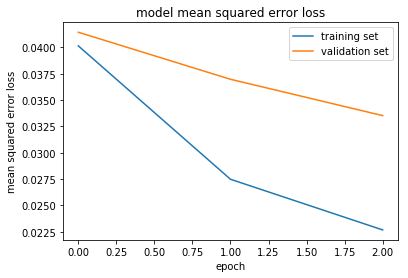

In [24]:
print(historyObj.history.keys())

### plot the training and validation loss for each epoch
plt.plot(historyObj.history['loss'])
plt.plot(historyObj.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
'''TODOs 
1) Left And Right Image Usage
2) why model is big? (OK)
3) opencv RGB Conv (OK)
4) cropping insidee Keras (OK)
5) add regulatization
6) CV methods -> canny ?
'''

In [10]:
import tensorflow
from keras.models import load_model
modelsxs = load_model('./model_Try1.h5')

In [3]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
